In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from config import config
from collections import OrderedDict

In [22]:
get_runtime_stats = '''SELECT nj.nlp_job_id, nj.name, nj.spl[1] as job_type, nj.spl[3] as job_index, nj.status, nj.date_started, nj.date_ended,
  case when nj.date_ended is not null then EXTRACT(MINUTE from (nj.date_ended - nj.date_started)) else 0 end as total_minutes,
  case when c.description = '0' then f.description else c.description end as feature_count,
  case when d.description  = '0' then  g.description else d.description end as patient_count,
  a.description as luigi_workers,
  b.description as batch_size,
  e.description as memory_caching

from (select *, regexp_split_to_array(name, '_') as spl from nlp.nlp_job) as nj
left JOIN nlp.nlp_job_status a on nj.nlp_job_id = a.nlp_job_id and a.status = 'PROPERTIES_LUIGI_WORKERS'
left JOIN nlp.nlp_job_status b on nj.nlp_job_id = b.nlp_job_id and b.status = 'PROPERTIES_BATCH_SIZE'
left JOIN nlp.nlp_job_status c on nj.nlp_job_id = c.nlp_job_id and c.status = 'STATS_FINAL_RESULTS'
left JOIN nlp.nlp_job_status d on nj.nlp_job_id = d.nlp_job_id and d.status = 'STATS_FINAL_SUBJECTS'
left JOIN nlp.nlp_job_status e on nj.nlp_job_id = e.nlp_job_id and e.status = 'PROPERTIES_USE_MEMORY_CACHING'
left JOIN nlp.nlp_job_status f on nj.nlp_job_id = f.nlp_job_id and f.status = 'STATS_INTERMEDIATE_RESULTS'
left JOIN nlp.nlp_job_status g on nj.nlp_job_id = g.nlp_job_id and g.status = 'STATS_INTERMEDIATE_SUBJECTS'
order by nj.nlp_job_id;
'''

In [23]:
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # read connection parameters
        params = config(filename='./clarity_pg.ini')
 
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)
 
        # create a cursor
        cur = conn.cursor()
        
         # execute a statement
        print('PostgreSQL database version:')
        cur.execute(get_runtime_stats)
 
        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
         # close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')
            
def run_query(query_str):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # read connection parameters
        params = config(filename='./clarity_pg.ini')
 
        # connect to the PostgreSQL server
        #print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)
 
        # create a cursor
        cur = conn.cursor()
        
        # execute stats collection query 
        cur.execute(query_str)

        df = pd.read_sql(query_str, conn)

         # close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            #print('Database connection closed.')
            
    return df
            

if __name__ == '__main__':
    #connect()
    results = run_query(get_runtime_stats)

In [259]:
def assign_config_labels(resultsdf):
    
    resultsdf['config_label'] = np.nan
    resultsdf['duration'] = np.nan
    
    for i, row in resultsdf.iterrows():
        
        if row['luigi_workers'] is None or row['memory_caching'] is None or row['status'] != "COMPLETED":
            continue
        
        # BASELINE CONFIGURATION:
        elif int(row['luigi_workers']) == 1 and row['memory_caching'] == "false":
        
            resultsdf.loc[i, 'config_label'] = 'baseline'
            resultsdf.loc[i, 'duration'] = row['date_ended'] - row['date_started']
            
    return resultsdf
        
        

In [296]:
def generate_df_for_violin_plots(resultsdf, N_OPTIMIZATIONS=2, N_SYNTH_QUERIES=1000):
    
    results = resultsdf.dropna()
    
    print(results.shape)
    print(results.head())
    
    configs = OrderedDict()
    results_set = OrderedDict()
    
    for i in range(len(results['config_label'].unique())):
        configs[i] = np.unique(results['config_label'])[i]

    N_CONFIGS = len(configs.keys())

    for i in range(N_CONFIGS):

        results_set[i] = {"name":configs[i], 
                      "opt_vec": np.array([np.random.randint(0,2,1) for i in range(N_OPTIMIZATIONS)]), 
                      "query_runtimes": np.array(results.loc[results['config_label']== configs[i], 'duration'])}
                      #"query_runtimes": np.array([np.random.randint(1,10*(i+1),1) for x in range(N_SYNTH_QUERIES)])}

    return results_set, configs

In [297]:
print(results.shape)
results.head()

temp = results.loc[results['status']=="COMPLETED"]
print(temp.shape)



(70, 15)
(68, 15)


In [262]:
#for col in results.columns:
    #print(col, results[col].unique())
    #print("\n")
   

In [303]:
out = assign_config_labels(results)
resset, configs = generate_df_for_violin_plots(out) 


(68, 15)
   nlp_job_id                        name        job_type job_index  \
0         648  SyntheticQuery_WithLimit_0  SyntheticQuery         0   
1         649  SyntheticQuery_WithLimit_1  SyntheticQuery         1   
2         650  SyntheticQuery_WithLimit_2  SyntheticQuery         2   
3         651  SyntheticQuery_WithLimit_3  SyntheticQuery         3   
4         652  SyntheticQuery_WithLimit_4  SyntheticQuery         4   

      status               date_started                 date_ended  \
0  COMPLETED 2018-12-03 13:58:54.154990 2018-12-03 14:26:45.137088   
1  COMPLETED 2018-12-03 14:26:56.112970 2018-12-03 14:54:37.494931   
2  COMPLETED 2018-12-03 14:54:43.032460 2018-12-03 15:09:12.791171   
3  COMPLETED 2018-12-03 15:09:14.078871 2018-12-03 15:25:52.935522   
4  COMPLETED 2018-12-03 15:26:00.265039 2018-12-03 15:38:33.611983   

   total_minutes feature_count patient_count luigi_workers batch_size  \
0           27.0          4045          1344             1        100 

In [264]:
# results_set = OrderedDict()
# N_CONFIGS = 1
# N_OPTIMIZATIONS = 5
# N_SYNTH_QUERIES = 1000

# for i in range(N_CONFIGS):
    
#     results_set[i] = {"name":"config_{}".format(i), 
#                       "opt_vec": np.array([np.random.randint(0,2,1) for i in range(N_OPTIMIZATIONS)]), 
#                       "query_runtimes": np.array([[np.random.randint(1,10*(i+1),1) for x in range(N_SYNTH_QUERIES)])}


In [299]:
N_CONFIGS = 1
N_OPTIMIZATIONS = 2
N_SYNTH_QUERIES = 68

def create_config_df(single_results_set, config_num):
    resdf = pd.DataFrame(index = [i for i in range(N_SYNTH_QUERIES)])
    resdf['config'] = config_num
    
    for i in range(N_OPTIMIZATIONS):
        resdf.loc[:,'opt_{}'.format(i)] = single_results_set['opt_vec'][i]
    
    resdf.loc[:, 'runtime'] = single_results_set['query_runtimes']
    return resdf

resdf = create_config_df(resset[0], 0) 
print(resset[0]['query_runtimes'].mean(), resset[0]['query_runtimes'].max())


0 days 00:43:00.148382 0 days 01:40:51.378582


In [304]:
def plot_syn_query_runtimes_by_config(results_set, configs):
    
    names = [results_set[i]['name'] for i in results_set.keys()]
    resdf = pd.DataFrame(index = [i for i in range(N_SYNTH_QUERIES)])
    
    for i in range(N_CONFIGS):
        resdf[configs[i]] = [x.total_seconds()*(1/60) for x in results_set[i]['query_runtimes']]

    fig_dims = (10, 7)
    fig, ax = plt.subplots(figsize=fig_dims)
    ax = sns.violinplot(data = resdf, inner="quartile", palette="Spectral") #inner="stick"
    ax.set(xlabel='ClarityNLP Platform Configurations', ylabel='Synthetic Query Runtimes (minutes)')
    ax.set(title=
           "Distribution of Synthetic Query Runtimes for Different Combinations of Optimizations \n \
           (n_queries = {}; dashed lines represent quartiles)".format(N_SYNTH_QUERIES))
    
    

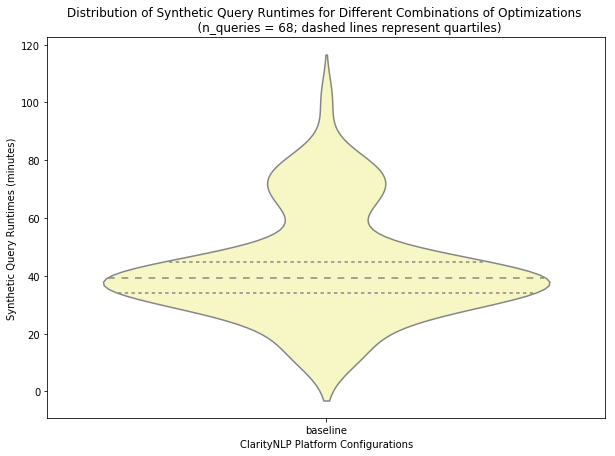

In [305]:
plot_syn_query_runtimes_by_config(resset, configs)



In [316]:
def plot_predicted_runtime_as_function_of_opt_vector(results_set):
    
    resdf = pd.DataFrame(index = [i for i in range(N_SYNTH_QUERIES*N_CONFIGS)])
    
    for i in results_set.keys():
        
        tempdf = create_config_df(results_set[i], i)
        
        if resdf.empty:
            resdf = tempdf
        else:
            resdf = resdf.append(tempdf)
    print(resdf.head())

plot_predicted_runtime_as_function_of_opt_vector(resset) 


   config  opt_0  opt_1         runtime
0       0      0      0 00:27:50.982098
1       0      0      0 00:27:41.381961
2       0      0      0 00:14:29.758711
3       0      0      0 00:16:38.856651
4       0      0      0 00:12:33.346944


In [317]:
plot_predicted_runtime_as_function_of_opt_vector(resset)


   config  opt_0  opt_1         runtime
0       0      0      0 00:27:50.982098
1       0      0      0 00:27:41.381961
2       0      0      0 00:14:29.758711
3       0      0      0 00:16:38.856651
4       0      0      0 00:12:33.346944
